# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [4]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
#from keras.layers.core import Activation
from keras.utils import pad_sequences

In [36]:
#use this cell to import additional libraries or define helper functions
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, MaxPooling1D, TimeDistributed, Flatten, BatchNormalization
from keras.regularizers import l1_l2
import keras.optimizers



## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [6]:
#Load your data into a pandas dataframe here
df = pd.read_csv("/content/household_power_clean.csv")

In [37]:
#create your training and validation sets here

#assign size for data subset
df_sample = df.sample(frac=0.01, random_state=42)

#take random data subset
#split data subset 80/20 for train/validation
split_idx = int(len(df_sample) * 0.8)
train_df = df_sample.iloc[:split_idx]
val_df = df_sample.iloc[split_idx:]


In [8]:
# Reset the indices for cleanliness
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [9]:
seq_arrays = []
seq_labs = []

sequence_length = 10  # Example: Use 10 previous time steps to make prediction
predictive_horizon = 1  # Example: Predict the next time step


for i in range(len(train_df) - sequence_length - predictive_horizon + 1):
    seq_arrays.append(train_df['Global_active_power'].iloc[i:i+sequence_length].values)  # Input sequence
    seq_labs.append(train_df['Global_active_power'].iloc[i+sequence_length+predictive_horizon-1])  # Output prediction

# Convert to arrays if needed, depending on how you plan to use them in training
import numpy as np
seq_arrays = np.array(seq_arrays)
seq_labs = np.array(seq_labs)


In [16]:
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

# Initialize as empty lists
seq_arrays = []
seq_labs = []

# Iterate over the training set to create sequences and corresponding labels
for i in range(len(train_df) - seq_length - ph + 1):
    seq = train_df[feat_cols].iloc[i:i+seq_length].values
    # The label should be just the value at the predictive horizon, not an array
    label = train_df[feat_cols].iloc[i+seq_length+ph-1].values[0]  # Assuming single feature prediction
    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert to numpy arrays
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)  # Do not reshape

# Assert the shapes
assert(seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df) - seq_length - ph + 1,))


In [18]:


seq_arrays = []  # List to hold input sequences
seq_labs = []  # List to hold output labels

# Iterate through train_df to create sequences and corresponding labels
for i in range(len(train_df) - seq_length - ph + 1):
    # Extract the sequence of GAP readings
    seq = train_df[feat_cols].iloc[i:i + seq_length].values

    # Extract the label (GAP reading at the predictive horizon)
    label = train_df[feat_cols].iloc[i + seq_length + ph - 1].values[0]  # Assuming we're predicting a single value

    # Append the sequence and label to their respective lists
    seq_arrays.append(seq)
    seq_labs.append(label)

# Convert lists to numpy arrays
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)

# Now, let's check the shapes
print("seq_arrays shape:", seq_arrays.shape)
print("seq_labs shape:", seq_labs.shape)

# Assert the shapes to ensure they match the expectations
assert(seq_arrays.shape == (len(train_df) - seq_length - ph + 1, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df) - seq_length - ph + 1,))


seq_arrays shape: (16360, 30, 1)
seq_labs shape: (16360,)


In [21]:
assert(seq_arrays.shape == (16360, seq_length, len(feat_cols)))
assert(seq_labs.shape == (16360,))

In [22]:
seq_arrays.shape

(16360, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: Assertions are used to enforce certain conditions in code, acting as safeguards against incorrect or unexpected data processing outcomes. They help maintain code quality, improve readability, and ensure that the code behaves as intended, making debugging and maintenance more manageable. Assert statements are used to verify that the shapes of the seq_arrays and seq_labs numpy arrays match the expected dimensions.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [23]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# Define path to save model
model_path = 'LSTM_model1.h5'

# Build the network
nb_features = len(feat_cols)  # 1 in this case
nb_out = 1  # Predicting a single output

model = Sequential()

# Add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# Add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer with linear activation
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print model summary
print(model.summary())

# Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history.history.keys())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252 (1008.00 Byte)
Trainable params: 252 (

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 - 0s - loss: 1.2135 - mse: 1.2135 - val_loss: 1.1432 - val_mse: 1.1432 - 235ms/epoch - 7ms/step
Epoch 3/100
32/32 - 0s - loss: 1.1932 - mse: 1.1932 - val_loss: 1.1451 - val_mse: 1.1451 - 220ms/epoch - 7ms/step
Epoch 4/100
32/32 - 0s - loss: 1.1773 - mse: 1.1773 - val_loss: 1.1431 - val_mse: 1.1431 - 237ms/epoch - 7ms/step
Epoch 5/100
32/32 - 0s - loss: 1.1664 - mse: 1.1664 - val_loss: 1.1417 - val_mse: 1.1417 - 228ms/epoch - 7ms/step
Epoch 6/100
32/32 - 0s - loss: 1.1582 - mse: 1.1582 - val_loss: 1.1473 - val_mse: 1.1473 - 216ms/epoch - 7ms/step
Epoch 7/100
32/32 - 0s - loss: 1.1609 - mse: 1.1609 - val_loss: 1.1450 - val_mse: 1.1450 - 210ms/epoch - 7ms/step
Epoch 8/100
32/32 - 0s - loss: 1.1489 - mse: 1.1489 - val_loss: 1.1415 - val_mse: 1.1415 - 231ms/epoch - 7ms/step
Epoch 9/100
32/32 - 0s - loss: 1.1437 - mse: 1.1437 - val_loss: 1.1416 - val_mse: 1.1416 - 218ms/epoch - 7ms/step
Epoch 10/100
32/32 - 0s - loss: 1.1425 - mse: 1.1425 - val_loss: 1.1419 - val_mse: 1.1419 - 211ms/ep

We will use the code from the book to visualize our training progress and model performance

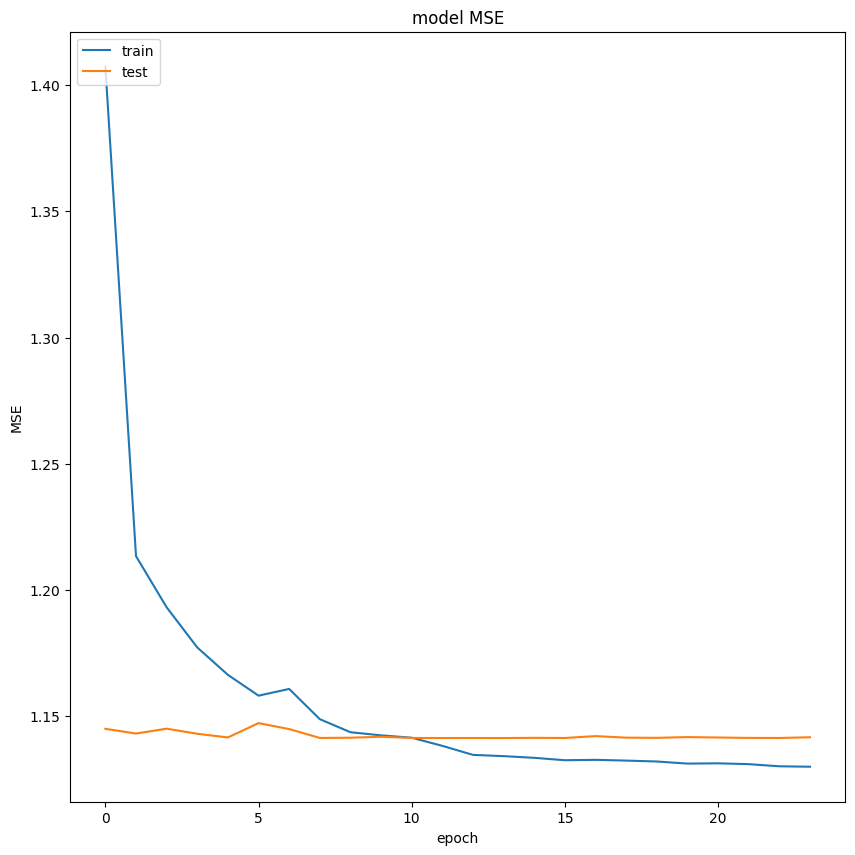

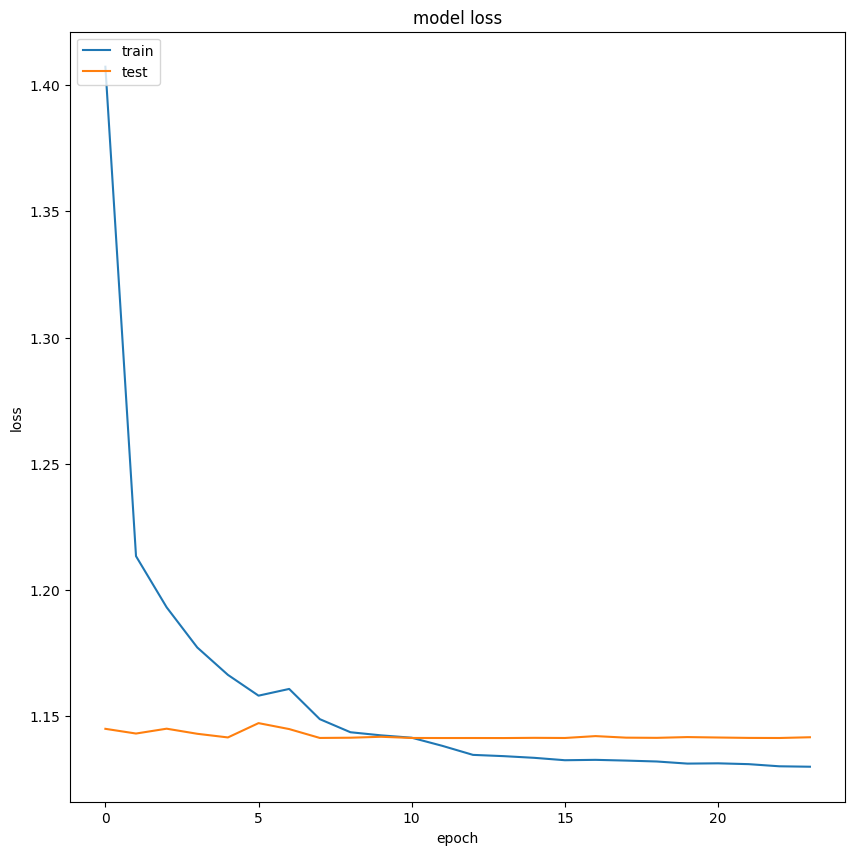

In [24]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function in Keras is designed to standardize the lengths of sequences in a dataset by either truncating them or padding them with zeros (or another specified value) so that all sequences in the dataset have the same length. This is useful in batch processing of sequence data where the input tensors need to be of the same shape.

In the context of time series forecasting with LSTM models, where the most recent observations are often the most relevant for making predictions, it's generally preferable to use 'pre' padding. This ensures that the LSTM model always has the most recent observations at the end of the sequence, closest to the point of prediction, even if the sequence needed to be padded to reach the required length.

In [26]:


val_arrays = []
val_labs = []

# Assuming val_df is your validation DataFrame and 'Global_active_power' is the feature column
for i in range(2, len(val_df)):  # Start from 2 readings
    if i + ph < len(val_df):  # Ensure there's enough data for the label
        # Create a sequence ending at the current reading, with a minimum length of 2 readings
        seq_end = i + 1  # The current reading is included in the sequence
        seq_start = max(0, seq_end - seq_length)  # Calculate the start index of the sequence
        input_seq = val_df['Global_active_power'].iloc[seq_start:seq_end].values.tolist()  # Convert to list for padding

        # Label is the GAP measurement at the predictive horizon
        label = val_df['Global_active_power'].iloc[i + ph]

        val_arrays.append(input_seq)  # Append the sequence (list) to val_arrays
        val_labs.append(label)  # Append the label to val_labs

# Use the pad_sequences function on your input sequences, padding with 'pre'
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre')

# Convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)  # Directly convert to np.float32


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [29]:
print("Shape of val_arrays:", val_arrays.shape)


Shape of val_arrays: (4092, 30)


In [30]:
val_arrays = val_arrays.reshape((val_arrays.shape[0], val_arrays.shape[1], 1))


128/128 - 0s - loss: 1.0969 - mse: 1.0969 - 361ms/epoch - 3ms/step

MSE: 1.0968552827835083
128/128 [==============================] - 1s 3ms/step


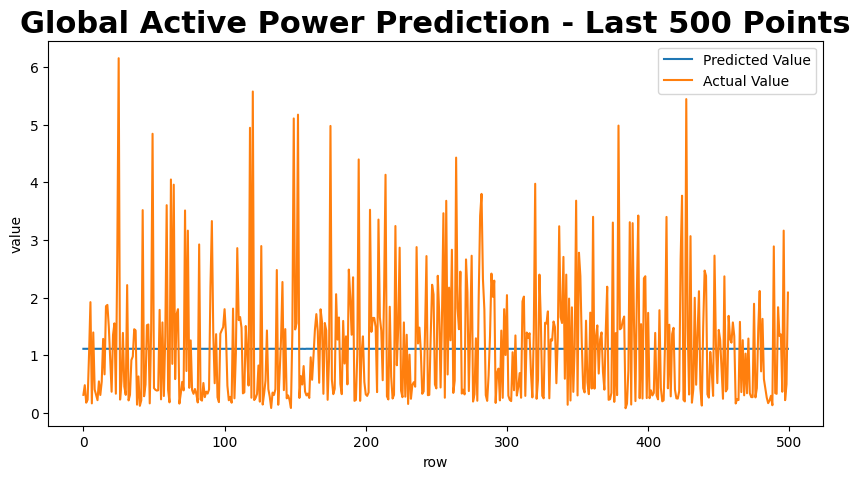

In [31]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The predicted values seem to follow the general trend of the actual values, which suggests that the model has learned some patterns in the data. However, the predicted values appear to have less variance than the actual values, they don't reach the same peaks and troughs, which is common in time series forecasting models.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: Add more variables, adjustl learning rate and optimizer, modify sequence length and predictive horizon, modify number of LSTM units

In [35]:


# Define the new model
model = Sequential()

# Maybe start with a 1D Conv layer to extract features across the time steps
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# The output from Conv1D will be 3-dimensional (batch_size, new_steps, filters), which can be fed into LSTM layers
# If the sequence is still too long after Conv1D and MaxPooling1D, you might need to adjust the pooling size or add additional pooling layers

# Add LSTM layers with more units
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(units=30, return_sequences=False))
model.add(Dropout(0.5))

# Add a Dense layer with L1 and L2 regularization
model.add(Dense(units=20, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))

# Output layer with linear activation for regression
model.add(Dense(units=1, activation='linear'))

# Compile the model with a different optimizer and/or learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print model summary
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 64)            256       
                                                                 
 batch_normalization_2 (Bat  (None, 28, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 14, 50)            23000     
                                                                 
 dropout_8 (Dropout)         (None, 14, 50)           

128/128 - 3s - loss: 3.9528 - mse: 2.6380 - 3s/epoch - 20ms/step

MSE: 2.637993574142456
128/128 [==============================] - 1s 3ms/step


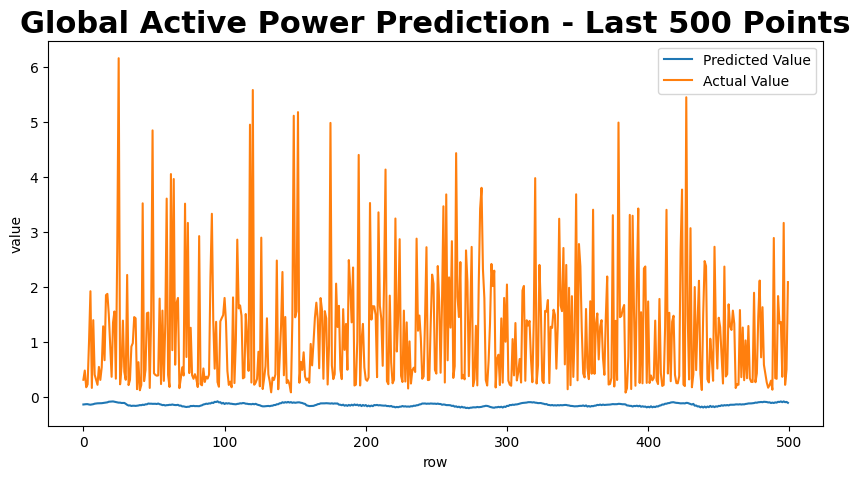

In [34]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:  it appears that the model's predictions are not closely following the actual values, especially in terms of capturing the peaks in the Global Active Power. The predicted values are consistently underestimating the actual consumption, indicating that the model may not be capturing the variability of the data effectively.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Choosing between a simple linear regression model and a complex LSTM model for predicting electricity usage in a home boils down to a trade-off between accuracy and practicality. If the prediction needs to be really precise and the patterns in electricity use are complex, the LSTM model is likely the better bet. However, it's more demanding in terms of computing power and energy, which might not be ideal for a small, battery-operated device in a home. On the other hand, linear regression is much easier on resources, quicker, and simpler to use, but it might not catch all the nuances in the electricity usage patterns. So, if the goal is to keep things simple and efficient for a small device, and the predictions don't need to be super detailed, then linear regression could be the way to go.

In [38]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  librsvg2-bin
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 1,871 kB of archives.
After this operation, 6,019 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 librsvg2-bin amd64 2.52.5+dfsg-3ubuntu0.2 [1,871 kB]
Fetched 1,871 kB in 2s (1,050 kB/s)
Selecting previously unselected package librsvg2-bin.
(Reading database ... 121747 files and directories currently installed.)
Preparing to unpack .../librsvg2-bin_2.52.5+dfsg-3ubuntu0.2_amd64.deb ...
Unpacking librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Setting up librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>